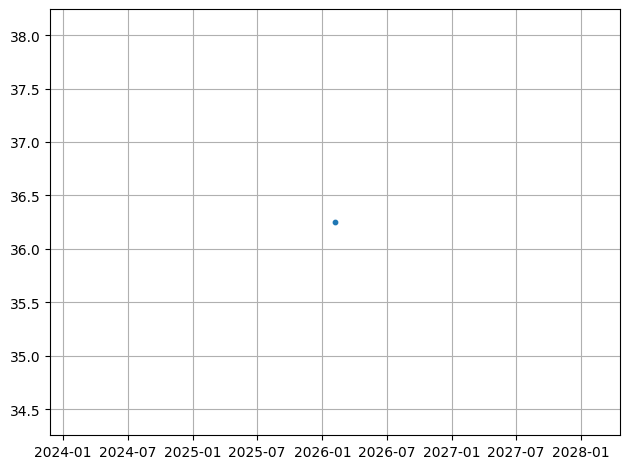

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=1)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [2]:
 
df_plot.tail(20)


,Time,Value
3075,2026-02-06 06:43:41,36.25


In [3]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/Weather.csv"

# Přeskočíme prvních 5 řádků, kde nejsou data
df_netatmo = pd.read_csv(path, skiprows=5)

# Oprava názvů sloupců
df_netatmo.columns = ["timestamp", "time_str", "temperature", "humidity", "empty"]

# Odstranění prázdného sloupce
df_netatmo = df_netatmo.drop(columns=["empty"])

# Převod timestamp → datetime
df_netatmo["time_utc"] = pd.to_datetime(df_netatmo["timestamp"], unit="s")

# Převod textového času → datetime
df_netatmo["time_local"] = pd.to_datetime(df_netatmo["time_str"])

df_netatmo


,timestamp,time_str,temperature,humidity,time_utc,time_local
0,1767222900,2026/01/01 00:15:00,1.5,86,2025-12-31 23:15:00,2026-01-01 00:15:00
1,1767224700,2026/01/01 00:45:00,1.6,85,2025-12-31 23:45:00,2026-01-01 00:45:00
2,1767226500,2026/01/01 01:15:00,1.7,85,2026-01-01 00:15:00,2026-01-01 01:15:00
3,1767228300,2026/01/01 01:45:00,1.8,85,2026-01-01 00:45:00,2026-01-01 01:45:00
4,1767230100,2026/01/01 02:15:00,1.8,85,2026-01-01 01:15:00,2026-01-01 02:15:00
...,...,...,...,...,...,...
1737,1770349500,2026/02/06 04:45:00,4.1,94,2026-02-06 03:45:00,2026-02-06 04:45:00
1738,1770351300,2026/02/06 05:15:00,4.1,94,2026-02-06 04:15:00,2026-02-06 05:15:00
1739,1770353100,2026/02/06 05:45:00,4.0,94,2026-02-06 04:45:00,2026-02-06 05:45:00
1740,1770354900,2026/02/06 06:15:00,4.1,95,2026-02-06 05:15:00,2026-02-06 06:15:00


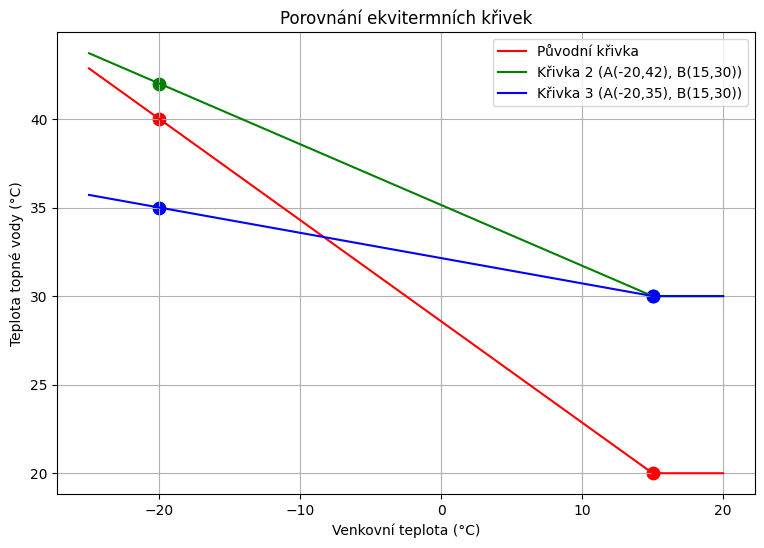

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# 2) Druhá křivka (A(-20,42), B(15,30) – tvoje stará verze)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# 3) Nová křivka podle bodů A(-20,35) a B(15,30)
def hokejka3(temp_in):
    if temp_in <= 15:
        return -0.142857 * temp_in + 32.14286
    else:
        return 30

# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]
temps_out_3 = [hokejka3(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Křivka 2 (A(-20,42), B(15,30))", color="green")
plt.plot(temps_in, temps_out_3, label="Křivka 3 (A(-20,35), B(15,30))", color="blue")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80)

# Body křivky 2
plt.scatter([-20, 15], [42, 30], color="green", s=80)

# Body křivky 3
plt.scatter([-20, 15], [35, 30], color="blue", s=80)

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

plt.show()


In [5]:
import pandas as pd

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/40) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# Sloupec Boiler_water
df_netatmo["Boiler_water"] = df_netatmo["temperature"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temperature"].apply(hokejka2)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)


,timestamp,time_str,temperature,humidity,time_utc,time_local,Boiler_water,Boiler_water_2
1732,1770340500,2026/02/06 02:15:00,4.1,94,2026-02-06 01:15:00,2026-02-06 02:15:00,26.228545,33.737286
1733,1770342300,2026/02/06 02:45:00,4.2,94,2026-02-06 01:45:00,2026-02-06 02:45:00,26.171402,33.703001
1734,1770344100,2026/02/06 03:15:00,4.1,94,2026-02-06 02:15:00,2026-02-06 03:15:00,26.228545,33.737286
1735,1770345900,2026/02/06 03:45:00,4.1,94,2026-02-06 02:45:00,2026-02-06 03:45:00,26.228545,33.737286
1736,1770347700,2026/02/06 04:15:00,4.1,94,2026-02-06 03:15:00,2026-02-06 04:15:00,26.228545,33.737286
1737,1770349500,2026/02/06 04:45:00,4.1,94,2026-02-06 03:45:00,2026-02-06 04:45:00,26.228545,33.737286
1738,1770351300,2026/02/06 05:15:00,4.1,94,2026-02-06 04:15:00,2026-02-06 05:15:00,26.228545,33.737286
1739,1770353100,2026/02/06 05:45:00,4.0,94,2026-02-06 04:45:00,2026-02-06 05:45:00,26.285688,33.771572
1740,1770354900,2026/02/06 06:15:00,4.1,95,2026-02-06 05:15:00,2026-02-06 06:15:00,26.228545,33.737286
1741,1770356700,2026/02/06 06:45:00,4.1,95,2026-02-06 05:45:00,2026-02-06 06:45:00,26.228545,33.737286


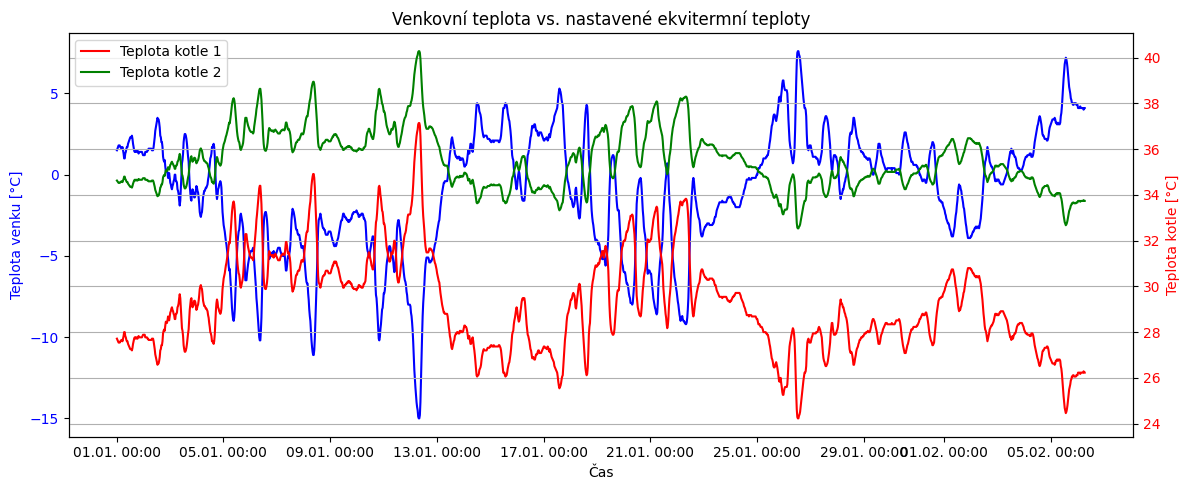

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

# Hlavní osa
ax = plt.gca()

# Venkovní teplota
ax.plot(df_netatmo["time_local"], df_netatmo["temperature"], color="blue")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa (Boiler_water)
ax2 = ax.twinx()
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Teplota kotle 1")
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Teplota kotle 2")

ax2.set_ylabel("Teplota kotle [°C]", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Titulek a popisky
plt.title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

# Legenda pro vedlejší osu
ax2.legend(loc="upper left")

plt.grid(True)
plt.tight_layout()
plt.show()


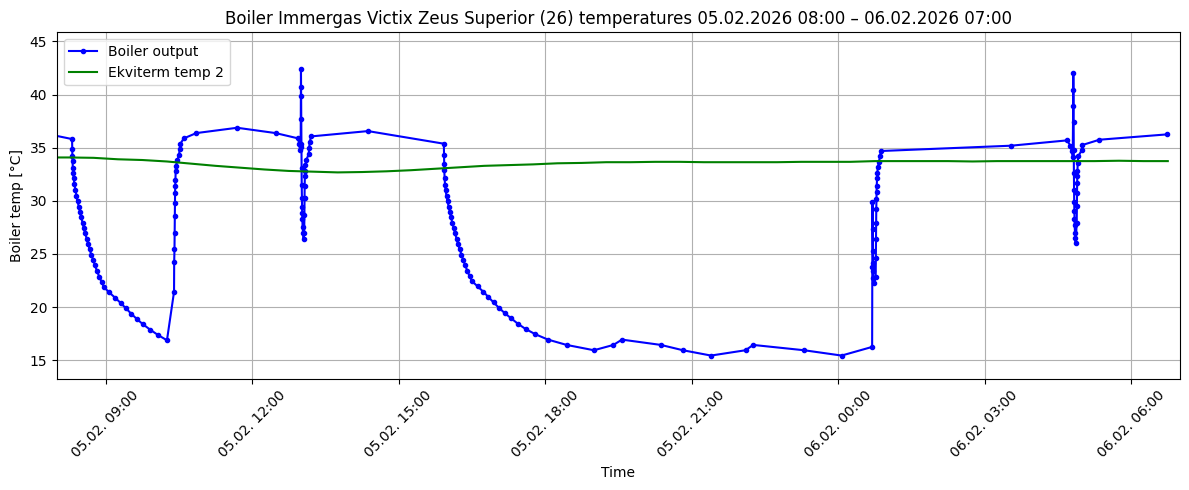

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-05 8:00:00")
end_time   = pd.Timestamp("2026-02-06 7:00:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df["Time"], df["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



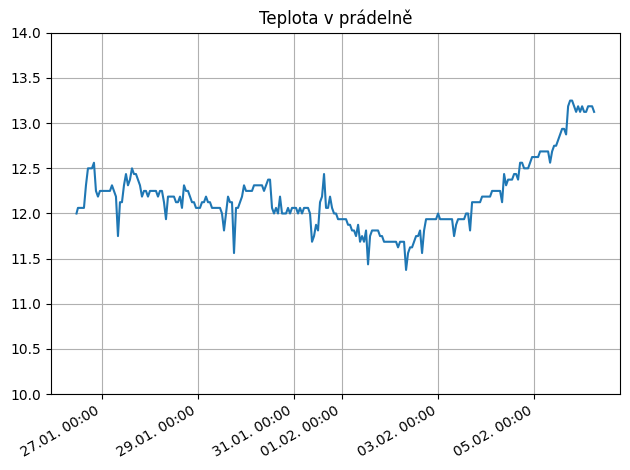

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import mplcursors

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
# df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 14)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"], linestyle="-", marker=None)
# ax.plot(df_pradelna["cas"], df_pradelna["tepl"], marker=".")
# ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=5)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
# mplcursors.cursor(hover=True)
plt.show()




In [9]:
with open("teplota_pradelna.csv") as f: 
    for _ in range(10): 
        print(f.readline().strip())

datetime,temperature_C
2026-01-26 11:15:44,12.0
2026-01-26 12:00:03,12.062
2026-01-26 13:00:03,12.062
2026-01-26 14:00:03,12.062
2026-01-26 15:00:03,12.062
2026-01-26 16:00:03,12.312
2026-01-26 17:00:03,12.5
2026-01-26 18:00:03,12.5
2026-01-26 19:00:03,12.5


In [10]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/climate.csv"

# Přeskočíme prvních 6 řádků (metadata + prázdné řádky)
df_climate = pd.read_csv(path, skiprows=6)

# Odstraníme poslední prázdný sloupec
df_climate = df_climate.iloc[:, :6]

# Přejmenujeme sloupce přesně podle CSV
df_climate.columns = [
    "timestamp",
    "time_str",
    "temperature",
    "setpoint",
    "boiler_on",
    "boiler_off"
]

# Převod timestamp → datetime
df_climate["time_utc"] = pd.to_datetime(df_climate["timestamp"], unit="s")

# Převod textového času → datetime
df_climate["time_local"] = pd.to_datetime(df_climate["time_str"])

# Výpis řádků, kde je setpoint < ... 
df_climate[df_climate["setpoint"] < 22]

,timestamp,time_str,temperature,setpoint,boiler_on,boiler_off,time_utc,time_local
1568,1770045300,2026/02/02 16:15:00,22.8,21.1,0,1452,2026-02-02 15:15:00,2026-02-02 16:15:00
1580,1770066900,2026/02/02 22:15:00,22.2,21.0,419,1194,2026-02-02 21:15:00,2026-02-02 22:15:00
1581,1770068700,2026/02/02 22:45:00,22.1,21.0,0,1797,2026-02-02 21:45:00,2026-02-02 22:45:00
1582,1770070500,2026/02/02 23:15:00,22.0,21.0,0,1808,2026-02-02 22:15:00,2026-02-02 23:15:00
1583,1770072300,2026/02/02 23:45:00,22.0,21.0,0,1796,2026-02-02 22:45:00,2026-02-02 23:45:00
1628,1770153300,2026/02/03 22:15:00,22.5,21.4,614,1194,2026-02-03 21:15:00,2026-02-03 22:15:00
1629,1770155100,2026/02/03 22:45:00,22.4,21.0,0,1797,2026-02-03 21:45:00,2026-02-03 22:45:00
1630,1770156900,2026/02/03 23:15:00,22.4,21.0,0,1807,2026-02-03 22:15:00,2026-02-03 23:15:00
1631,1770158700,2026/02/03 23:45:00,22.3,21.0,0,1797,2026-02-03 22:45:00,2026-02-03 23:45:00
1632,1770160500,2026/02/04 00:15:00,22.2,21.0,0,1797,2026-02-03 23:15:00,2026-02-04 00:15:00


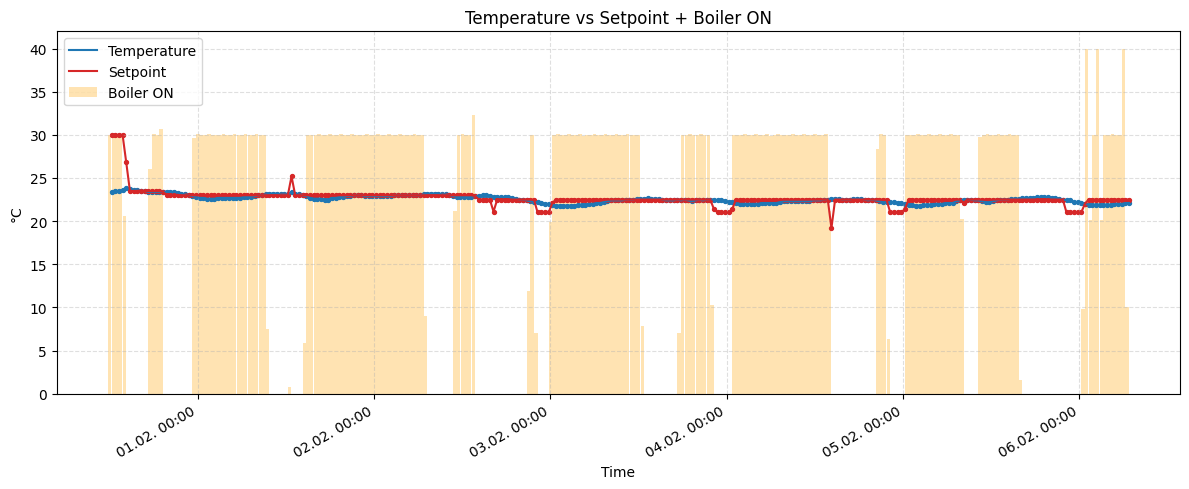

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/climate.csv"

# Přeskočíme prvních 6 řádků (metadata)
df_climate = pd.read_csv(path, skiprows=6)

# Odstraníme poslední prázdný sloupec
df_climate = df_climate.iloc[:, :6]

# Přejmenujeme sloupce
df_climate.columns = [
    "timestamp",
    "time_str",
    "temperature",
    "setpoint",
    "boiler_on",
    "boiler_off"
]

# Převod timestamp → datetime
df_climate["time_utc"] = pd.to_datetime(df_climate["timestamp"], unit="s")

# Převod textového času → datetime
df_climate["time_local"] = pd.to_datetime(df_climate["time_str"])

# -----------------------------
# FILTR OD 31.1. 12:00
# -----------------------------
start = pd.to_datetime("2026-01-31 12:00")
df_range = df_climate[df_climate["time_local"] >= start].copy()

# -----------------------------
# PŮLHODINOVÉ AGREGACE
# -----------------------------
df_range["half_hour"] = df_range["time_local"].dt.floor("30min")

# boiler_on je v sekundách za 10 minut → max 600
# půlhodina = 3 intervaly → max 1800
# chceme max 30 → 1800 / 30 = 60
df_bars = (
    df_range.groupby("half_hour")["boiler_on"]
    .sum()
    .reset_index()
)

df_bars["intensity"] = df_bars["boiler_on"] / 60.0

# -----------------------------
# GRAF
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

# Bar graf (intenzita topení)
ax.bar(
    df_bars["half_hour"],
    df_bars["intensity"],
    width=0.02,
    color="orange",
    alpha=0.3,
    label="Boiler ON"
)

# Čáry
ax.plot(df_range["time_local"], df_range["temperature"],
        label="Temperature", color="tab:blue", linewidth=1.5)

ax.plot(df_range["time_local"], df_range["setpoint"],
        label="Setpoint", color="tab:red", linewidth=1.5)

# Malé body
ax.scatter(df_range["time_local"], df_range["temperature"], s=8, color="tab:blue")
ax.scatter(df_range["time_local"], df_range["setpoint"], s=8, color="tab:red")

# Popisky
ax.set_title("Temperature vs Setpoint + Boiler ON")
ax.set_xlabel("Time")
ax.set_ylabel("°C")

ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()
